In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA, KernelPCA
from scipy.spatial.distance import pdist, cdist, squareform, cosine, euclidean
from sklearn.datasets import make_circles
from sklearn.preprocessing import StandardScaler,normalize
import data_manipulation as dm
import SODA
from tsfresh import extract_features
from tsfresh import select_features
from tsfresh.utilities.dataframe_functions import impute
import pandas as pd

In [2]:
def DataSlicer (P_data,y, id_per_group=20, Choice='All'):
    ''' Function to Slice a time series dataset into several datasets
    for save RAM during model execution
    
    Parameters:
    ------
    Output_Id : int
        identifier for the dataset
    
    id_per_group: int, optional
        number of time series per division (default is 20)
    
    Choice : str, optional
        option of data, can be ['Main Data', 'Eminence Data', 'All'] (default is 'All')
    
    
    Returns: 
    -------
    dictionary, with the following items
        'FinalTarget': np.array
            targets of the entire dataset
        'M_N_groups': int
            number of groups
        'ID': int
            identifier for the dataset
        'N_IDs': int
            number of time series
    
    '''
    
    print('Data Slicer Control Output')
    print('----------------------------------')
    
    # Loading the required input 
    
    columns = P_data.shape[1]
    
    Final_Target = y

    print('Main Data: ' + str(P_data.shape))
    print('Labels: ' + str(Final_Target.shape))

    ###______________________________________________________________________###
    ###                     ProDiMes Slicing Parameters                      ###


    P_N_Ids = int(np.amax(P_data,axis=0)[0])
    P_last_group = int(P_N_Ids % id_per_group)

    if P_last_group != 0:
        P_N_groups = int((P_N_Ids / id_per_group) + 1)
    else:
        P_N_groups = int (P_N_Ids / id_per_group)


    print ('Total Number of Ids: ' + str(P_N_Ids))
    print ('Main data Number of groups: ' + str(P_N_groups ))
    print ('Main data Last group: ' + str(P_last_group ))
    print ('___________________________________________')
    
    ###______________________________________________________________________###
    ###                      Slicing Prodimes Data                           ###

    if (Choice =='Main Data') or (Choice =='All'):
    
        for i in range (P_N_groups):                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               
        
            Data = np.zeros(((id_per_group),columns))
        
            for j in range (id_per_group):
                
                if (P_last_group == 0):
            
                    Data[j,:] = P_data [(i * id_per_group) + j ,:]
                
                if (P_last_group != 0) and (i < (P_N_groups - 1)):
            
                    Data[j,:] = P_data [(i * id_per_group) + j ,:]
            
            if (P_last_group != 0) and (i == (P_N_groups - 1)):  
                Data = np.zeros(((P_last_group),columns))
            
                for j in range (P_last_group):
                    Data[j ,:] = P_data [(i * id_per_group) + j,:]
        
            np.savetxt(('kernel/Data_' + str(i) + '.csv'), Data, delimiter = ',')

    np.savetxt(('kernel/FinalTarget.csv'), Final_Target, delimiter = ',')
    
    # Now change back to Base directory
    
    Output = {'FinalTarget': Final_Target,
              'M_N_groups': P_N_groups,
              'N_IDs': P_N_Ids}
    
    return Output

In [3]:
def TSFRESH(D_S_parameters):
    ''' Function to extract features of the time series using
    TSFRESH method
    
    Parameters:
    ------
    D_S_parameters : dictionary, with the following items
        'FinalTarget': np.array
            targets of the entire dataset
        'M_N_groups': int
            number of groups
        'ID': int
            identifier for the dataset
        'N_IDs': int
            number of time series
    
    
    Returns: 
    -------
    list
        a list of string with the name of the extracted features by TSFRESH
        
    '''
    
    print('             ')
    print('TSFRESH Control Output')
    print('----------------------------------')
    
    ###______________________________________________________________________###
    ###                         Feature Extraction                           ###

    P_N_groups = D_S_parameters['M_N_groups']
    y = D_S_parameters['FinalTarget']
    
    for i in range(P_N_groups):
        
        Data = np.genfromtxt('kernel/Data_' + str(i) + '.csv', delimiter=',')
        data = pd.DataFrame(Data, columns= ['id'] + ['Attributs' + str(x) for x in range(1,(Data.shape[1]))])
        
        Data_extracted_features = extract_features(data,column_id = "id",n_jobs=4,disable_progressbar=True)
        extracted_names = Data_extracted_features.columns.tolist()
        
        if i == 0:
            Data_Matrix = Data_extracted_features.values
        else:
            new_data = Data_extracted_features.values
            Data_Matrix = np.vstack((Data_Matrix, new_data))
            
    features = pd.DataFrame(Data_Matrix, columns= extracted_names)
    features = impute(features)
    features_filtered_1 = select_features(features, y,n_jobs=4)
    features_filtered_1.sort_index(inplace = True)
    
    print("Number of Extracted Features: {}".format(len(extracted_names)))
    
    return features_filtered_1

# Uploading Data-set

In [4]:
b_name='Input_Background_1.csv'

background = np.genfromtxt(b_name, delimiter=',')
background = background[1:,:]
print("     .Background Loaded...")

s_name='Input_Signal_1.csv'

signal = np.genfromtxt(s_name, delimiter=',')
signal = signal[1:,:]
print("     .Signal Loaded...")

     .Background Loaded...
     .Signal Loaded...


# Reducing Data samples

In [5]:
# Reducing data samples

background, _ = dm.divide(background, 100, 750)
signal, _ = dm.divide(signal, 100, 750)

L1, _ = background.shape

In [6]:
#concatenating backgropund with signal
X = np.vstack((background,signal))

# Normalizing concatenate data
X_norm = normalize(X,norm='max', axis=0)

# Creating labels and event ID
y = []
ID = []
for i in range(len(background)):y.append(0)
for i in range(len(signal)):y.append(1)
for i in range(1,len(X)+1):ID.append(i)
    
#Creating Data Frames
data = np.hstack((np.array(ID).reshape((-1,1)),X))
norm_data = np.hstack((np.array(ID).reshape((-1,1)),X_norm))
y = np.array(y)


# TSFRESH

In [7]:
D_S_parameters = DataSlicer(data,y)

n_extracted_features = TSFRESH(D_S_parameters)

Data Slicer Control Output
----------------------------------
Main Data: (1500, 22)
Labels: (1500,)
Total Number of Ids: 1500
Main data Number of groups: 75
Main data Last group: 0
___________________________________________
             
TSFRESH Control Output
----------------------------------


/home/thiago/anaconda3/lib/python3.7/site-packages/tsfresh/utilities/dataframe_functions.py:172: RuntimeWarning: The columns ['Attributs1__mean_abs_change' 'Attributs1__mean_change'
 'Attributs1__mean_second_derivative_central' ...
 'Attributs21__permutation_entropy__dimension_5__tau_1'
 'Attributs21__permutation_entropy__dimension_6__tau_1'
 'Attributs21__permutation_entropy__dimension_7__tau_1'] did not have any finite values. Filling with zeros.
  df.iloc[:, np.where(is_col_non_finite)[0]].columns.values), RuntimeWarning)


Number of Extracted Features: 16359


In [8]:
D_S_parameters = DataSlicer(norm_data,y)

norm_extracted_features = TSFRESH(D_S_parameters)

Data Slicer Control Output
----------------------------------
Main Data: (1500, 22)
Labels: (1500,)
Total Number of Ids: 1500
Main data Number of groups: 75
Main data Last group: 0
___________________________________________
             
TSFRESH Control Output
----------------------------------


/home/thiago/anaconda3/lib/python3.7/site-packages/tsfresh/utilities/dataframe_functions.py:172: RuntimeWarning: The columns ['Attributs1__mean_abs_change' 'Attributs1__mean_change'
 'Attributs1__mean_second_derivative_central' ...
 'Attributs21__permutation_entropy__dimension_5__tau_1'
 'Attributs21__permutation_entropy__dimension_6__tau_1'
 'Attributs21__permutation_entropy__dimension_7__tau_1'] did not have any finite values. Filling with zeros.
  df.iloc[:, np.where(is_col_non_finite)[0]].columns.values), RuntimeWarning)


Number of Extracted Features: 16359


# None - Norm

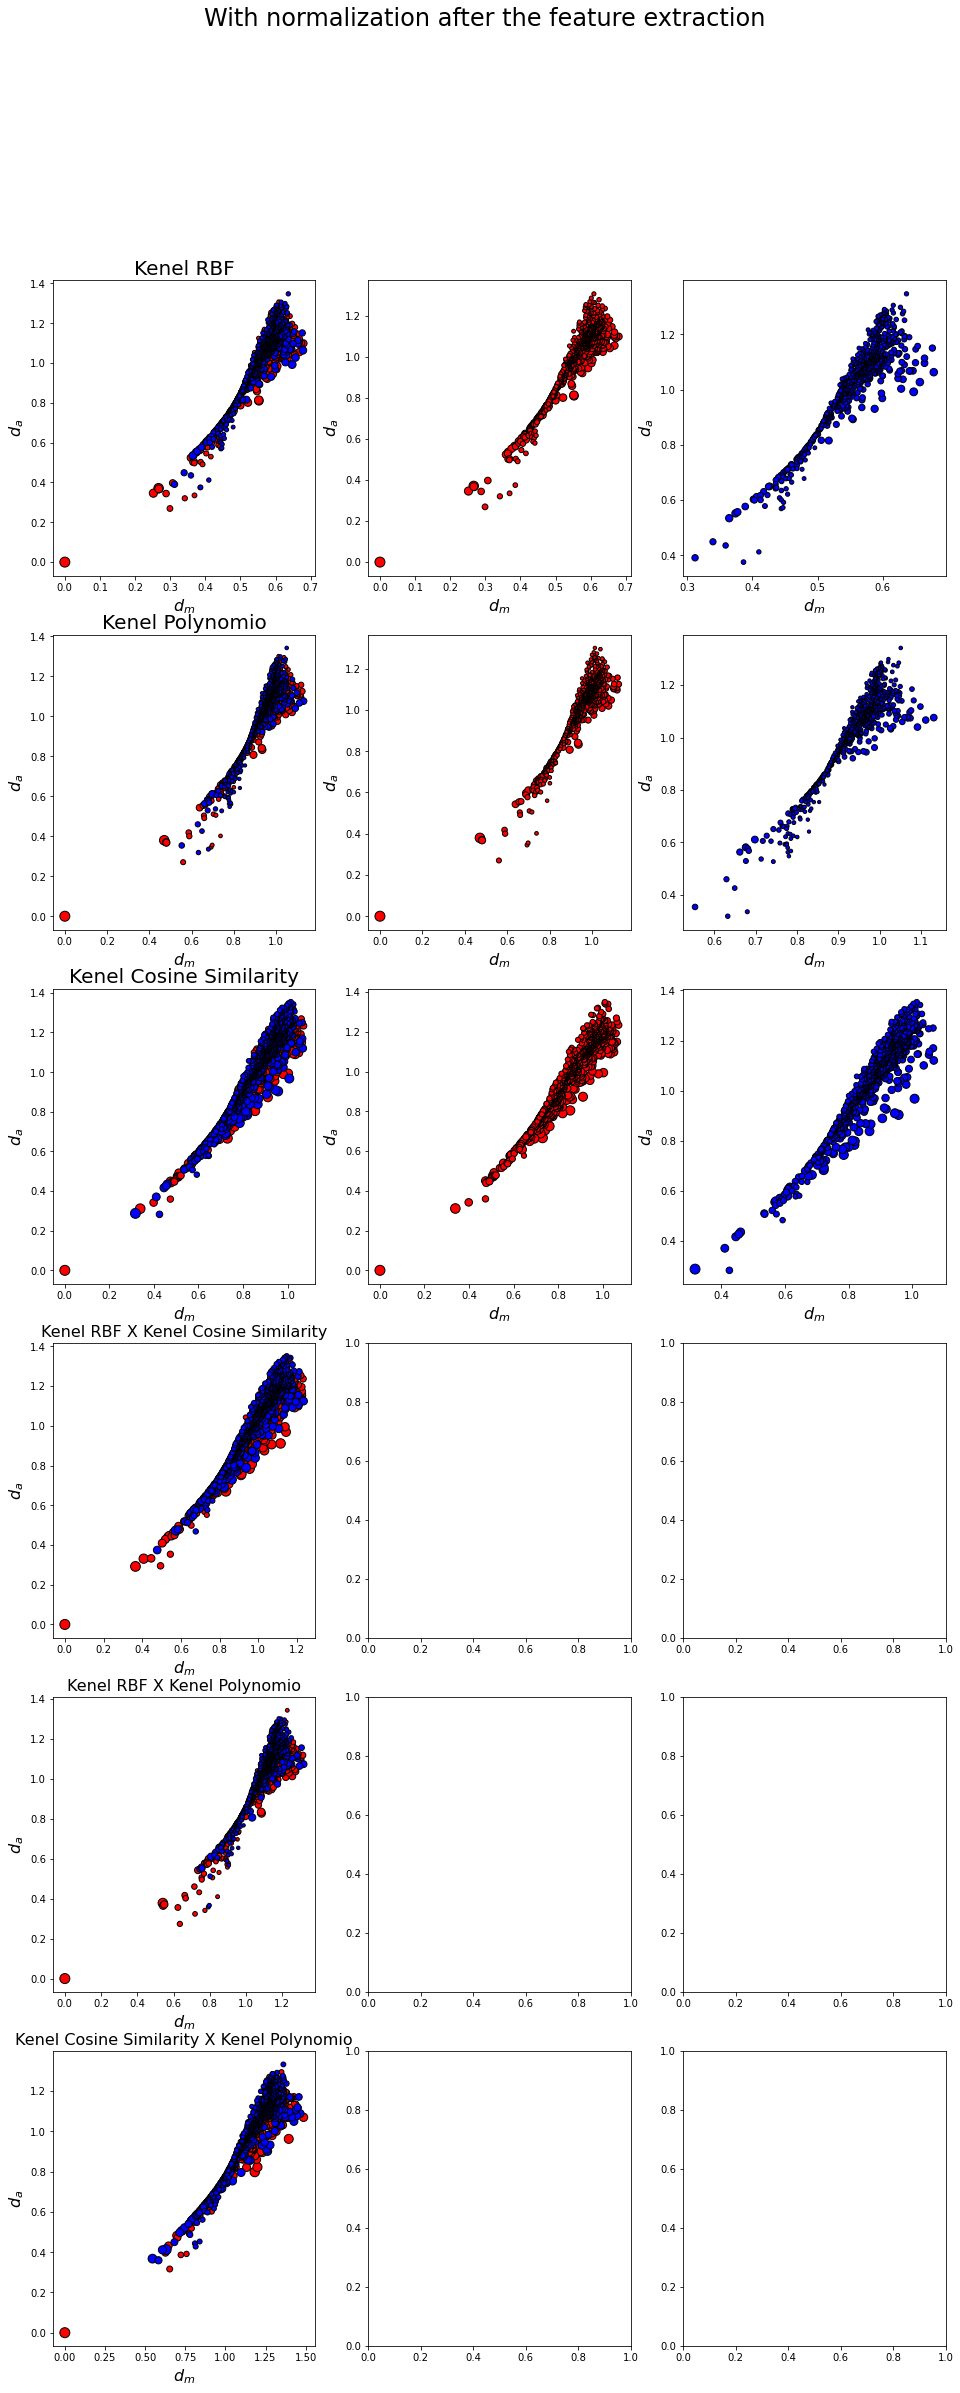

In [35]:
# defining Kernels
kernels = [
    KernelPCA(kernel="rbf", fit_inverse_transform=True, n_components=6),
    KernelPCA(kernel="poly", fit_inverse_transform=True, degree=3, n_components=6),
    KernelPCA(kernel="cosine", fit_inverse_transform=True, n_components=6)
]

names= ['Kenel RBF','Kenel Polynomio','Kenel Cosine Similarity']

groups = [
    [KernelPCA(kernel="rbf", fit_inverse_transform=True, n_components=6),
     KernelPCA(kernel="cosine", fit_inverse_transform=True, n_components=6)],
    [KernelPCA(kernel="rbf", fit_inverse_transform=True, n_components=6),
     KernelPCA(kernel="poly", fit_inverse_transform=True, degree=3, n_components=6)],
    [KernelPCA(kernel="cosine", fit_inverse_transform=True, n_components=6),
     KernelPCA(kernel="poly", fit_inverse_transform=True, degree=3, n_components=6)]
]

groups_names = ['Kenel RBF X Kenel Cosine Similarity',
                'Kenel RBF X Kenel Polynomio',
                'Kenel Cosine Similarity X Kenel Polynomio']

# Extracting Statistical Attributes
#extracted_features = dm.statistics_attributes(X)
#extracted_features = X
extracted_features = n_extracted_features


# Normalizing features
extracted_features = normalize(extracted_features,norm='max', axis=0)

# Definin plot parameters
fig = plt.figure(figsize=[16,38])
fig.suptitle('With normalization after the feature extraction',fontsize=24)
ax = fig.subplots(6,3)

j = 0

# Iterating into Kernels
for name, knl in zip(names, kernels):

    x_pca = knl.fit_transform(extracted_features)
    GD, Uniquesample, _, J = SODA.Globaldensity_Calculator(x_pca, 'euclidean')
    GD = normalize(GD.reshape((-1,1)),norm='max',axis=0)*100
    
    d_a = []
    d_m = []
    reds = []
    blues = []
    GD_reds = []
    GD_blues = []
    
    for i in range (len(Uniquesample)):
        d_a.append(np.sqrt(cosine(Uniquesample[0], Uniquesample[i])))
        d_m.append(euclidean(Uniquesample[0], Uniquesample[i]))
        
        if y[J[i]] == 0:
            blues.append(True)
            reds.append(False)
            GD_blues.append(GD[i])
        else:
            blues.append(False)
            reds.append(True)
            GD_reds.append(GD[i])

    d_a = np.array(d_a)
    d_m = np.array(d_m)
    
    #Separating background from signal

    ax[j,0].set_title(name,fontsize=20)

    ax[j,0].scatter(d_m[reds], d_a[reds], c="red",
    s=GD_reds, edgecolor='k')
    ax[j,0].scatter(d_m[blues], d_a[blues], c="blue",
    s=GD_blues, edgecolor='k')
    ax[j,0].set_xlabel("$d_m$",fontsize=16)
    ax[j,0].set_ylabel("$d_a$",fontsize=16)
    
    ax[j,0].set_title(name,fontsize=20)

    ax[j,1].scatter(d_m[reds], d_a[reds], c="red",
    s=GD_reds, edgecolor='k')
    ax[j,1].set_xlabel("$d_m$",fontsize=16)
    ax[j,1].set_ylabel("$d_a$",fontsize=16)
    
    ax[j,2].scatter(d_m[blues], d_a[blues], c="blue",
    s=GD_blues, edgecolor='k')
    ax[j,2].set_xlabel("$d_m$",fontsize=16)
    ax[j,2].set_ylabel("$d_a$",fontsize=16)
    
    j += 1  

# Iterating into Kernels
for name, knl in zip(groups_names, groups):
    knl1 = knl[0]
    knl2 = knl[1]
    
    x_pca1 = knl1.fit_transform(extracted_features)
    x_pca2 = knl2.fit_transform(extracted_features)
    x_pca = np.hstack((x_pca1,x_pca2))
    
    GD, Uniquesample, _, J = SODA.Globaldensity_Calculator(x_pca, 'euclidean')
    GD = normalize(GD.reshape((-1,1)),norm='max',axis=0)*100
    
    d_a = []
    d_m = []
    reds = []
    blues = []
    GD_reds = []
    GD_blues = []

    for i in range (len(Uniquesample)):
        d_a.append(np.sqrt(cosine(Uniquesample[0], Uniquesample[i])))
        d_m.append(euclidean(Uniquesample[0], Uniquesample[i]))
        
        if y[J[i]] == 0:
            blues.append(True)
            reds.append(False)
            GD_blues.append(GD[i])
        else:
            blues.append(False)
            reds.append(True)
            GD_reds.append(GD[i])

    d_a = np.array(d_a)
    d_m = np.array(d_m)
    
    #Separating background from signal

    ax[j,0].set_title(name,fontsize=16)

    ax[j,0].scatter(d_m[reds], d_a[reds], c="red",
                s=GD_reds, edgecolor='k')
    ax[j,0].scatter(d_m[blues], d_a[blues], c="blue",
                s=GD_blues, edgecolor='k')
    ax[j,0].set_xlabel("$d_m$",fontsize=16)
    ax[j,0].set_ylabel("$d_a$",fontsize=16)
    
    j += 1
    
plt.show
fig.savefig('results/None_Norm.png', bbox_inches='tight')

# None - Std

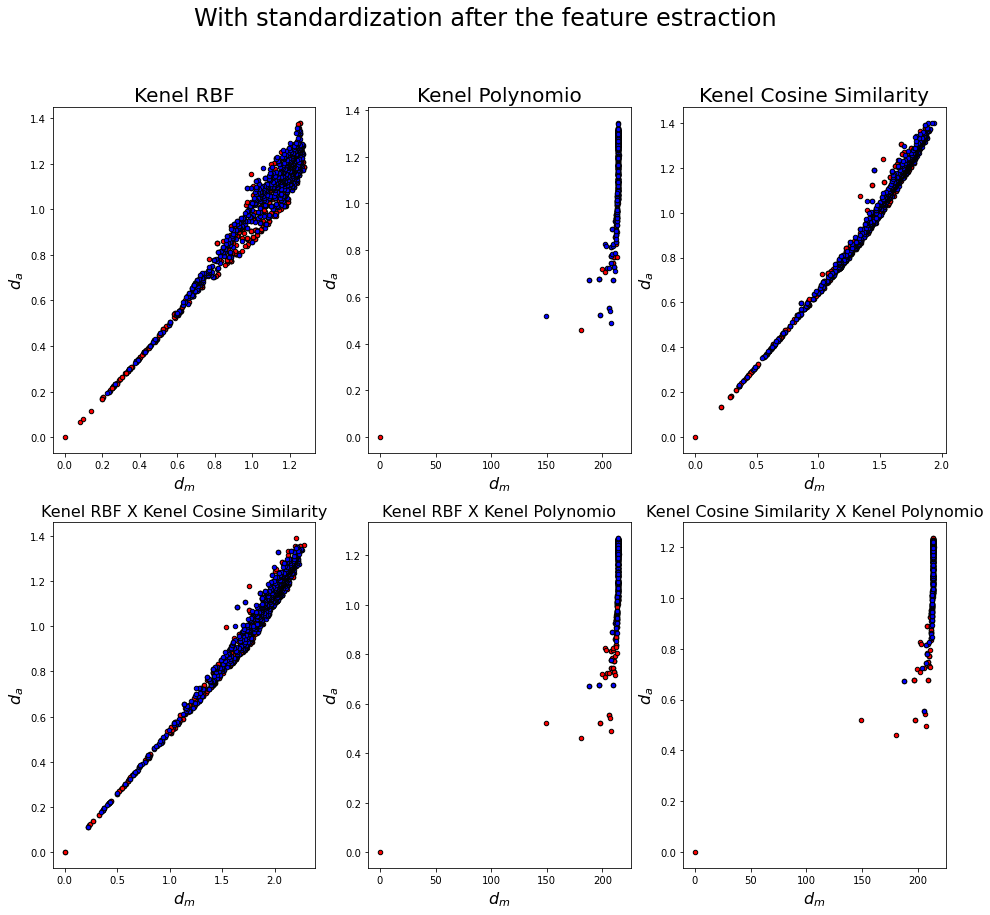

In [22]:
# defining Kernels
kernels = [
    KernelPCA(kernel="rbf", fit_inverse_transform=True, n_components=6),
    KernelPCA(kernel="poly", fit_inverse_transform=True, degree=3, n_components=6),
    KernelPCA(kernel="cosine", fit_inverse_transform=True, n_components=6)
]
names= ['Kenel RBF','Kenel Polynomio','Kenel Cosine Similarity']

# Extracting Statistical Attributes
#extracted_features = dm.statistics_attributes(X)
#extracted_features = X
extracted_features = n_extracted_features

#Standadization
scaler = StandardScaler().fit(extracted_features)
extracted_features = scaler.transform(extracted_features)

# Definin plot parameters
fig = plt.figure(figsize=[16,14])
fig.suptitle('With standardization after the feature estraction',fontsize=24)
ax = fig.subplots(2,3)

j = 0

# Iterating into Kernels
for name, knl in zip(names, kernels):

    x_pca = knl.fit_transform(extracted_features)
    _, Uniquesample, _, J = SODA.Globaldensity_Calculator(x_pca, 'euclidean')

    d_a = []
    d_m = []
    reds = []
    blues = []

    for i in range (len(Uniquesample)):
        d_a.append(np.sqrt(cosine(Uniquesample[0], Uniquesample[i])))
        d_m.append(euclidean(Uniquesample[0], Uniquesample[i]))
        
        if y[J[i]] == 0:
            blues.append(True)
            reds.append(False)
        else:
            blues.append(False)
            reds.append(True)

    d_a = np.array(d_a)
    d_m = np.array(d_m)
    
    #Separating background from signal

    ax[0,j].set_title(name,fontsize=20)

    ax[0,j].scatter(d_m[reds], d_a[reds], c="red",
                s=20, edgecolor='k')
    ax[0,j].scatter(d_m[blues], d_a[blues], c="blue",
                s=20, edgecolor='k')
    ax[0,j].set_xlabel("$d_m$",fontsize=16)
    ax[0,j].set_ylabel("$d_a$",fontsize=16)
    
    j += 1

j = 0    

# Iterating into Kernels
for name, knl in zip(groups_names, groups):
    knl1 = knl[0]
    knl2 = knl[1]
    
    x_pca1 = knl1.fit_transform(extracted_features)
    x_pca2 = knl2.fit_transform(extracted_features)
    x_pca = np.hstack((x_pca1,x_pca2))
    
    _, Uniquesample, _, J = SODA.Globaldensity_Calculator(x_pca, 'euclidean')

    d_a = []
    d_m = []
    reds = []
    blues = []

    for i in range (len(Uniquesample)):
        d_a.append(np.sqrt(cosine(Uniquesample[0], Uniquesample[i])))
        d_m.append(euclidean(Uniquesample[0], Uniquesample[i]))
        
        if y[J[i]] == 0:
            blues.append(True)
            reds.append(False)
        else:
            blues.append(False)
            reds.append(True)

    d_a = np.array(d_a)
    d_m = np.array(d_m)
    
    #Separating background from signal

    ax[1,j].set_title(name,fontsize=16)

    ax[1,j].scatter(d_m[reds], d_a[reds], c="red",
                s=20, edgecolor='k')
    ax[1,j].scatter(d_m[blues], d_a[blues], c="blue",
                s=20, edgecolor='k')
    ax[1,j].set_xlabel("$d_m$",fontsize=16)
    ax[1,j].set_ylabel("$d_a$",fontsize=16)
    
    j += 1
    
plt.show
fig.savefig('results/None_Std.png', bbox_inches='tight')

# Norm - Norm

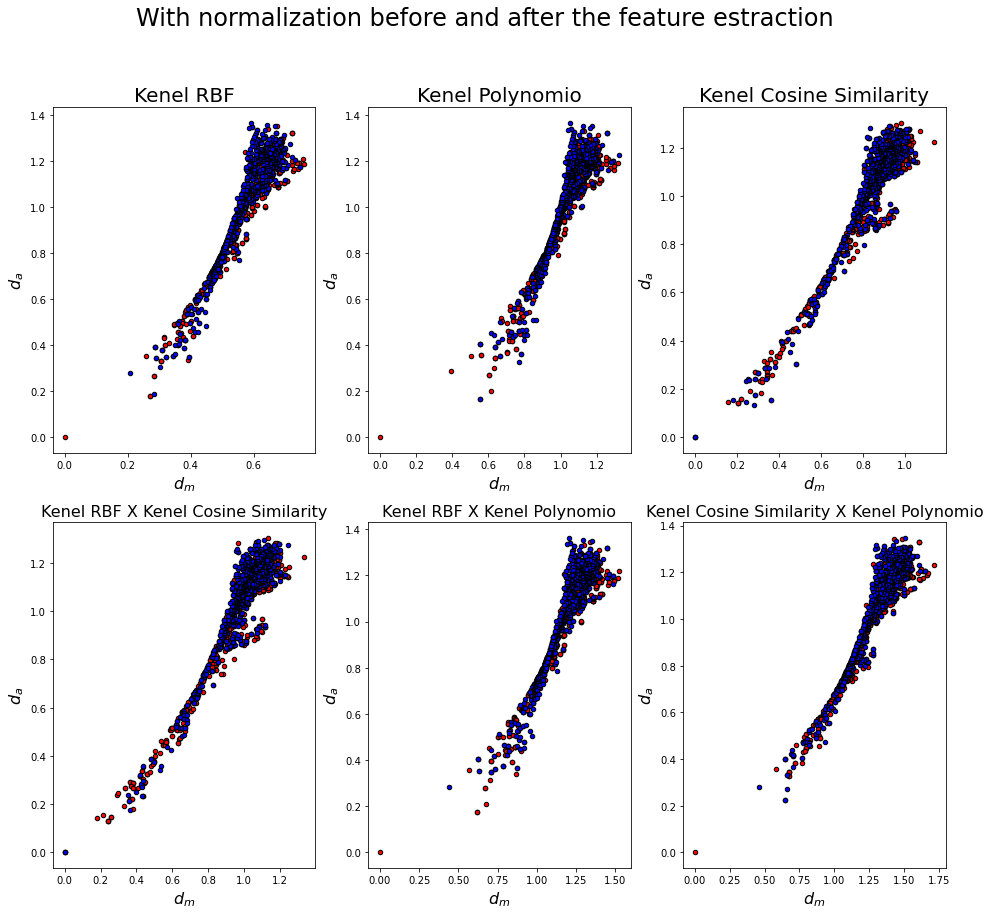

In [23]:
# defining Kernels
kernels = [
    KernelPCA(kernel="rbf", fit_inverse_transform=True, n_components=6),
    KernelPCA(kernel="poly", fit_inverse_transform=True, degree=3, n_components=6),
    KernelPCA(kernel="cosine", fit_inverse_transform=True, n_components=6)
]
names= ['Kenel RBF','Kenel Polynomio','Kenel Cosine Similarity']

# Normalizing Data-set
X_norm = normalize(X,norm='max', axis=0)

# Extracting Statistical Attributes
#extracted_features = dm.statistics_attributes(X_norm)
#extracted_features = X_norm
extracted_features = norm_extracted_features

# Normalizing features
extracted_features = normalize(extracted_features,norm='max', axis=0)

# Definin plot parameters
fig = plt.figure(figsize=[16,14])
fig.suptitle('With normalization before and after the feature estraction',fontsize=24)
ax = fig.subplots(2,3)

j = 0

# Iterating into Kernels
for name, knl in zip(names, kernels):

    x_pca = knl.fit_transform(extracted_features)
    _, Uniquesample, _, J = SODA.Globaldensity_Calculator(x_pca, 'euclidean')

    d_a = []
    d_m = []
    reds = []
    blues = []

    for i in range (len(Uniquesample)):
        d_a.append(np.sqrt(cosine(Uniquesample[0], Uniquesample[i])))
        d_m.append(euclidean(Uniquesample[0], Uniquesample[i]))
        
        if y[J[i]] == 0:
            blues.append(True)
            reds.append(False)
        else:
            blues.append(False)
            reds.append(True)

    d_a = np.array(d_a)
    d_m = np.array(d_m)
    
    #Separating background from signal

    ax[0,j].set_title(name,fontsize=20)

    ax[0,j].scatter(d_m[reds], d_a[reds], c="red",
                s=20, edgecolor='k')
    ax[0,j].scatter(d_m[blues], d_a[blues], c="blue",
                s=20, edgecolor='k')
    ax[0,j].set_xlabel("$d_m$",fontsize=16)
    ax[0,j].set_ylabel("$d_a$",fontsize=16)
    
    j += 1

j = 0    

# Iterating into Kernels
for name, knl in zip(groups_names, groups):
    knl1 = knl[0]
    knl2 = knl[1]
    
    x_pca1 = knl1.fit_transform(extracted_features)
    x_pca2 = knl2.fit_transform(extracted_features)
    x_pca = np.hstack((x_pca1,x_pca2))
    
    _, Uniquesample, _, J = SODA.Globaldensity_Calculator(x_pca, 'euclidean')

    d_a = []
    d_m = []
    reds = []
    blues = []

    for i in range (len(Uniquesample)):
        d_a.append(np.sqrt(cosine(Uniquesample[0], Uniquesample[i])))
        d_m.append(euclidean(Uniquesample[0], Uniquesample[i]))
        
        if y[J[i]] == 0:
            blues.append(True)
            reds.append(False)
        else:
            blues.append(False)
            reds.append(True)

    d_a = np.array(d_a)
    d_m = np.array(d_m)
    
    #Separating background from signal

    ax[1,j].set_title(name,fontsize=16)

    ax[1,j].scatter(d_m[reds], d_a[reds], c="red",
                s=20, edgecolor='k')
    ax[1,j].scatter(d_m[blues], d_a[blues], c="blue",
                s=20, edgecolor='k')
    ax[1,j].set_xlabel("$d_m$",fontsize=16)
    ax[1,j].set_ylabel("$d_a$",fontsize=16)
    
    j += 1
    
plt.show
fig.savefig('results/Norm_Norm.png', bbox_inches='tight')

# Norm - Std

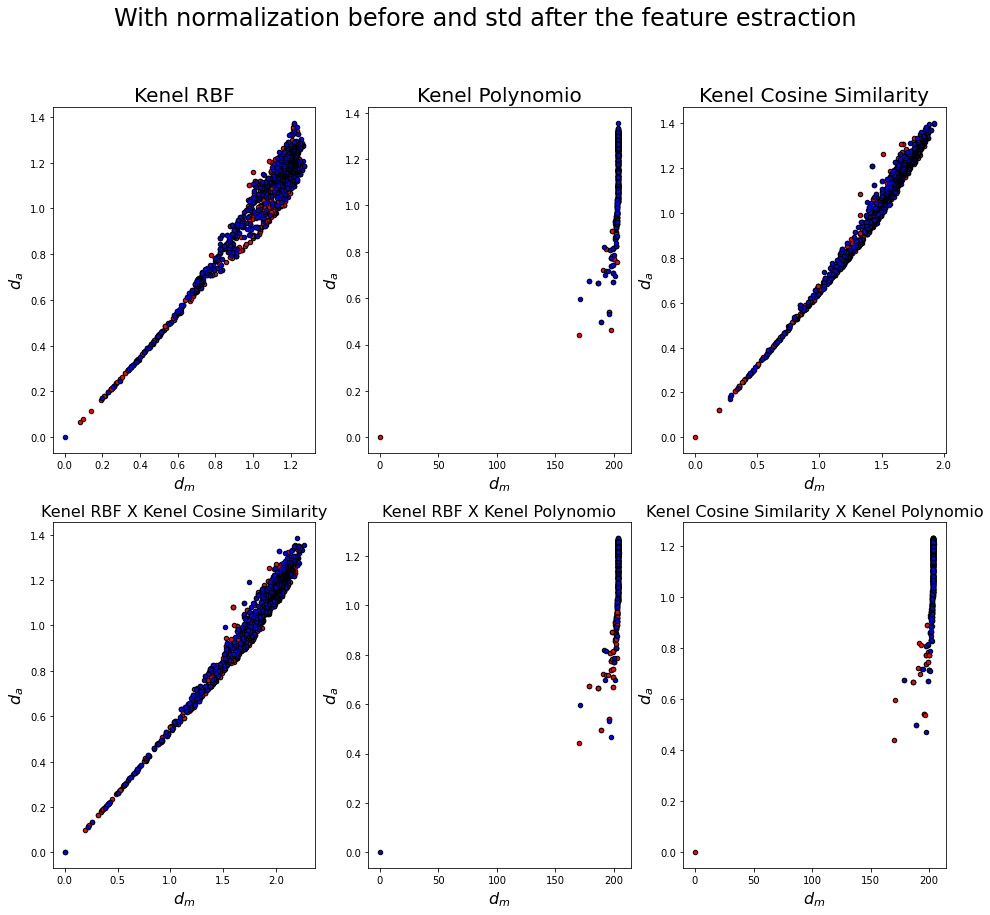

In [24]:
# defining Kernels
kernels = [
    KernelPCA(kernel="rbf", fit_inverse_transform=True, n_components=6),
    KernelPCA(kernel="poly", fit_inverse_transform=True, degree=3, n_components=6),
    KernelPCA(kernel="cosine", fit_inverse_transform=True, n_components=6)
]
names= ['Kenel RBF','Kenel Polynomio','Kenel Cosine Similarity']

# Normalizing Data-set
X_norm = normalize(X,norm='max', axis=0)

# Extracting Statistical Attributes
#extracted_features = dm.statistics_attributes(X_norm)
#extracted_features = X_norm
extracted_features = norm_extracted_features

#Standadization
scaler = StandardScaler().fit(extracted_features)
extracted_features = scaler.transform(extracted_features)

# Definin plot parameters
fig = plt.figure(figsize=[16,14])
fig.suptitle('With normalization before and std after the feature estraction',fontsize=24)
ax = fig.subplots(2,3)

j = 0

# Iterating into Kernels
for name, knl in zip(names, kernels):

    x_pca = knl.fit_transform(extracted_features)
    _, Uniquesample, _, J = SODA.Globaldensity_Calculator(x_pca, 'euclidean')

    d_a = []
    d_m = []
    reds = []
    blues = []

    for i in range (len(Uniquesample)):
        d_a.append(np.sqrt(cosine(Uniquesample[0], Uniquesample[i])))
        d_m.append(euclidean(Uniquesample[0], Uniquesample[i]))
        
        if y[J[i]] == 0:
            blues.append(True)
            reds.append(False)
        else:
            blues.append(False)
            reds.append(True)

    d_a = np.array(d_a)
    d_m = np.array(d_m)
    
    #Separating background from signal

    ax[0,j].set_title(name,fontsize=20)

    ax[0,j].scatter(d_m[reds], d_a[reds], c="red",
                s=20, edgecolor='k')
    ax[0,j].scatter(d_m[blues], d_a[blues], c="blue",
                s=20, edgecolor='k')
    ax[0,j].set_xlabel("$d_m$",fontsize=16)
    ax[0,j].set_ylabel("$d_a$",fontsize=16)
    
    j += 1

j = 0    

# Iterating into Kernels
for name, knl in zip(groups_names, groups):
    knl1 = knl[0]
    knl2 = knl[1]
    
    x_pca1 = knl1.fit_transform(extracted_features)
    x_pca2 = knl2.fit_transform(extracted_features)
    x_pca = np.hstack((x_pca1,x_pca2))
    
    _, Uniquesample, _, J = SODA.Globaldensity_Calculator(x_pca, 'euclidean')

    d_a = []
    d_m = []
    reds = []wsssssaaaaaaaaaaaaaaaa
    blues = []

    for i in range (len(Uniquesample)):
        d_a.append(np.sqrt(cosine(Uniquesample[0], Uniquesample[i])))
        d_m.append(euclidean(Uniquesample[0], Uniquesample[i]))
        
        if y[J[i]] == 0:
            blues.append(True)
            reds.append(False)
        else:
            blues.append(False)
            reds.append(True)

    d_a = np.array(d_a)
    d_m = np.array(d_m)
    
    #Separating background from signal

    ax[1,j].set_title(name,fontsize=16)

    ax[1,j].scatter(d_m[reds], d_a[reds], c="red",
                s=20, edgecolor='k')
    ax[1,j].scatter(d_m[blues], d_a[blues], c="blue",
                s=20, edgecolor='k')
    ax[1,j].set_xlabel("$d_m$",fontsize=16)
    ax[1,j].set_ylabel("$d_a$",fontsize=16)
    
    j += 1
    
plt.show
fig.savefig('results/Norm_Std.png', bbox_inches='tight')

# Norm - None

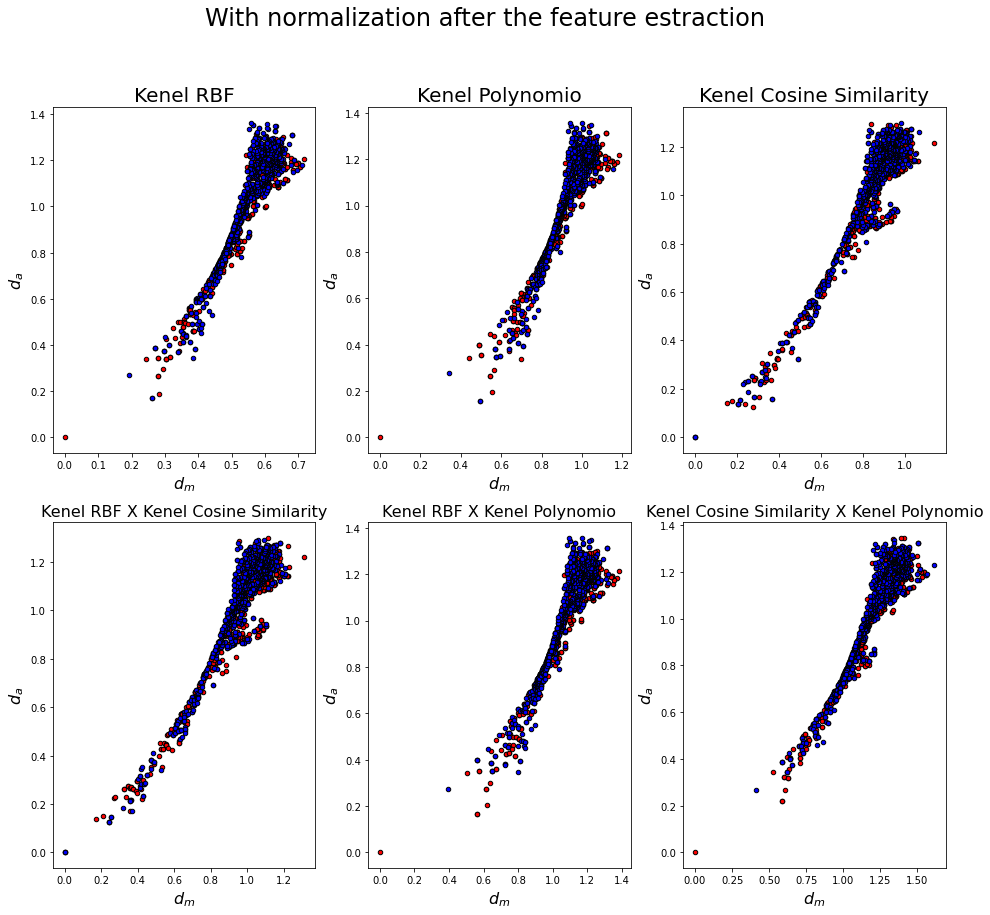

In [25]:
# defining Kernels
kernels = [
    KernelPCA(kernel="rbf", fit_inverse_transform=True, n_components=6),
    KernelPCA(kernel="poly", fit_inverse_transform=True, degree=3, n_components=6),
    KernelPCA(kernel="cosine", fit_inverse_transform=True, n_components=6)
]
names= ['Kenel RBF','Kenel Polynomio','Kenel Cosine Similarity']

# Normalizing Data-set
#X_norm = normalize(X,norm='max', axis=0)

# Extracting Statistical Attributes
#extracted_features = dm.statistics_attributes(X_norm)
#extracted_features = X_norm
extracted_features = norm_extracted_features

# Definin plot parameters
fig = plt.figure(figsize=[16,14])
fig.suptitle('With normalization after the feature estraction',fontsize=24)
ax = fig.subplots(2,3)

j = 0

# Iterating into Kernels
for name, knl in zip(names, kernels):

    x_pca = knl.fit_transform(extracted_features)
    _, Uniquesample, _, J = SODA.Globaldensity_Calculator(x_pca, 'euclidean')

    d_a = []
    d_m = []
    reds = []
    blues = []

    for i in range (len(Uniquesample)):
        d_a.append(np.sqrt(cosine(Uniquesample[0], Uniquesample[i])))
        d_m.append(euclidean(Uniquesample[0], Uniquesample[i]))
        
        if y[J[i]] == 0:
            blues.append(True)
            reds.append(False)
        else:
            blues.append(False)
            reds.append(True)

    d_a = np.array(d_a)
    d_m = np.array(d_m)
    
    #Separating background from signal

    ax[0,j].set_title(name,fontsize=20)

    ax[0,j].scatter(d_m[reds], d_a[reds], c="red",
                s=20, edgecolor='k')
    ax[0,j].scatter(d_m[blues], d_a[blues], c="blue",
                s=20, edgecolor='k')
    ax[0,j].set_xlabel("$d_m$",fontsize=16)
    ax[0,j].set_ylabel("$d_a$",fontsize=16)
    
    j += 1
    
j = 0    

# Iterating into Kernels
for name, knl in zip(groups_names, groups):
    knl1 = knl[0]
    knl2 = knl[1]
    
    x_pca1 = knl1.fit_transform(extracted_features)
    x_pca2 = knl2.fit_transform(extracted_features)
    x_pca = np.hstack((x_pca1,x_pca2))
    
    _, Uniquesample, _, J = SODA.Globaldensity_Calculator(x_pca, 'euclidean')

    d_a = []
    d_m = []
    reds = []
    blues = []

    for i in range (len(Uniquesample)):
        d_a.append(np.sqrt(cosine(Uniquesample[0], Uniquesample[i])))
        d_m.append(euclidean(Uniquesample[0], Uniquesample[i]))
        
        if y[J[i]] == 0:
            blues.append(True)
            reds.append(False)
        else:
            blues.append(False)
            reds.append(True)

    d_a = np.array(d_a)
    d_m = np.array(d_m)
    
    #Separating background from signal

    ax[1,j].set_title(name,fontsize=16)

    ax[1,j].scatter(d_m[reds], d_a[reds], c="red",
                s=20, edgecolor='k')
    ax[1,j].scatter(d_m[blues], d_a[blues], c="blue",
                s=20, edgecolor='k')
    ax[1,j].set_xlabel("$d_m$",fontsize=16)
    ax[1,j].set_ylabel("$d_a$",fontsize=16)
    
    j += 1
    
plt.show
fig.savefig('results/Norm_None.png', bbox_inches='tight')